# AI4EO challenge: Air Quality & Health Challenge

I am an introduction

## Table of contents

1. [Pre-processing](#pre-processing)

    1.1 [AOIs and target grids](#aoi-and-target-grids)    
    1.2 [Stations](#stations)    
    1.3 [CAMS](#cams)    
    1.4 [S5P](#s5p)    
    1.5 [S3](#s3)    
    1.6 [MODIS](#modis)    
    1.7 [ERA5](#era5)     
    1.8 [Land cover](#land-cover)     
    1.9 [DEM](#dem)    
    1.10 [SPOT](#spot)  
    1.11 [Data Merging](#data-merging)    

    
2. [Exploratory analysis](#exploratory-analysis)
    
3. [Modelling and validation](#modelling-and-validation)

4. [Prediction](#prediction)
    

## Pre-processing <a name="pre-processing"></a>

In [1]:
# Built-in modules
import os
import gzip
import shutil
from pathlib import Path
from datetime import datetime, timedelta
import glob
import re
import warnings
from collections import defaultdict

# Basics of Python data handling and visualization
import fs
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm
from shapely import wkt

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOPatch, EOTask, LinearWorkflow, FeatureType, AddFeature, MapFeatureTask, MergeFeatureTask, RemoveFeature,LoadTask, SaveTask, OverwritePermission
from sentinelhub import bbox_to_dimensions, bbox_to_resolution
from eolearn.io import ExportToTiff

# Visualisation utils
from utils import (get_extent, 
                   draw_outline, 
                   draw_bbox, 
                   draw_feature, 
                   draw_true_color,
                   unzip_file,
                   load_tiffs,
                   days_to_datetimes,
                   datetimes_to_days,
                   reproject_tiff,
                   upscale_tiff,
                   mask_tiff)

In [2]:
DATA_DIR = Path('training_dataset_south_africa')
AOIS = ['South_Africa']

In [3]:
OFFSET = 2100
NO_DATA_VALUE = -9999.0

### AOI and target grids  <a name="aoi-and-target-grids"></a>

Here I think we should read the 6 target files (3 CAMS, 3 S5P) and derive boundaries, EPSG and reference grids to pre-process the rest of the data to match it.

### Stations <a name="stations"></a>

### CAMS <a name="cams"></a>
EPSG: 4326. 
Temporal resolution: North Italy: hourly, California & South Africa: 3 hours . 
Spatial resolution: North Italy: 10km, California & South Africa: 40km.

In [4]:
cams_train_dir = DATA_DIR/AOIS[0]/'CAMS'

cams_products = sorted(os.listdir(cams_train_dir))
cams_products

['NO2_surface', 'PM2_5']

In [5]:
cams_eops = [load_tiffs(cams_train_dir/cams_p, 
                        (FeatureType.DATA, cams_p), 
                        offset=OFFSET,
                        data_source='cams') 
             for cams_p in cams_products]

In [6]:
cams_eop = EOPatch(data={'NO2_surface': cams_eops[0].data['NO2_surface'], 
                         'PM2_5': cams_eops[1].data['PM2_5']},
                   meta_info={'Names_NO2_surface': cams_eops[0].meta_info['Names'],
                              'Names_PM2_5': cams_eops[1].meta_info['Names']},
                     timestamp=cams_eops[0].timestamp,
                     bbox=cams_eops[0].bbox)
del cams_eops


In [7]:
## ALL required tasks to merge hourly CAMS data

## Task to put all measurments of same day together 
add_cams = (FeatureType.DATA, 'Daily_CAMS')
add_daily_cams = AddFeature(add_cams)

## Task to merge hourly measurmens ( Mean value) 
mean = MapFeatureTask((FeatureType.DATA,'Daily_CAMS'),  # input features
                         (FeatureType.DATA_TIMELESS,'mean_daily_cams'),  # output feature
                         np.nanmean,                    # a function to apply to each feature
                         axis=0) 

## Task to export the merged tiff (mean of daily measurments)
export_tiff = ExportToTiff((FeatureType.DATA_TIMELESS, 'mean_daily_cams'))

## location of exported tiff
mean_CAMS_location = str(DATA_DIR/AOIS[0])+'/mean_cams'
if not os.path.isdir(mean_CAMS_location):
    os.makedirs(mean_CAMS_location)
    for i in cams_products:
        os.mkdir(mean_CAMS_location + '/' + i)

        
## Task to delete the daily mean CAMS feature and start the process again for another day
reomve_feature1 = (FeatureType.DATA, 'Daily_CAMS')
remove_daily_cams = RemoveFeature(reomve_feature1)

reomve_feature2 = (FeatureType.DATA_TIMELESS, 'mean_daily_cams')
remove_mean_daily_cams = RemoveFeature(reomve_feature2)


In [8]:
## Function to merge hourly CAMS data using the previous tasks
def meanCAMS(eopatch, cams_product):
    ## extract day index of each tiff
    daily_index = []
    for name in eopatch.meta_info['Names_'+ cams_product]:
        day, hour = name.split('_day')[-1].split('_')
        daily_index.append(day)

    ## extract the indices of the same day    
    c =  defaultdict(list)
    for idx , day in enumerate(daily_index):
        c[day].append(idx)
        
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for key,locs in c.items():
            all_hours_cams = []
            for l in locs:
                #print(l)
                hour_cams = eopatch.data[cams_product][l]
                #print(band.shape)
                all_hours_cams.append(hour_cams)    

            daily_cams = np.stack(all_hours_cams, axis=0)
            add_daily_cams.execute(eopatch,daily_cams)
            mean(eopatch)
            tiffname = eopatch.meta_info['Names_'+ cams_product][l]
            
            tiffname = tiffname.replace(tiffname[-6:], "00")
            export_tiff.execute(eopatch, filename=str(mean_CAMS_location)+'/'+cams_product+'/'+tiffname)
            remove_daily_cams(eopatch)
            remove_mean_daily_cams(eopatch)
    

In [9]:
## Apply the merge function on CAMS products
for cams_product in cams_products:
    meanCAMS(cams_eop,cams_product)

del cams_eop

In [10]:
## Load the MEAN daily CAMS products
mean_CAMS_location=Path(mean_CAMS_location)
mean_cams_eops = [load_tiffs(mean_CAMS_location/cams_p, 
                        (FeatureType.DATA, cams_p), 
                        offset=OFFSET,
                        data_source='cams') 
             for cams_p in cams_products]

## Merge them into a single EOPatch
mean_cams_eop = EOPatch(data={'NO2_surface': mean_cams_eops[0].data['NO2_surface'], 
                         'PM2_5': mean_cams_eops[1].data['PM2_5']},
                   meta_info={'Names_NO2_surface': mean_cams_eops[0].meta_info['Names'],
                              'Names_PM2_5': mean_cams_eops[1].meta_info['Names']},
                     timestamp=mean_cams_eops[0].timestamp,
                     bbox=mean_cams_eops[0].bbox)
del mean_cams_eops
mean_cams_eop

EOPatch(
  data: {
    NO2_surface: numpy.ndarray(shape=(92, 8, 8, 1), dtype=float32)
    PM2_5: numpy.ndarray(shape=(92, 8, 8, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    Names_NO2_surface: ['CAMS_NO2_day2141_h00.tif', ..., 'CAMS_NO2_day2232_h00.tif'], length=92
    Names_PM2_5: ['CAMS_PM2_5_day2141_h00.tif', ..., 'CAMS_PM2_5_day2232_h00.tif'], length=92
  }
  bbox: BBox(((26.125, -28.315595626831055), (32.125, -22.315595626831055)), crs=CRS('4326'))
  timestamp: [datetime.datetime(1900, 2, 10, 0, 0), ..., datetime.datetime(1900, 5, 12, 0, 0)], length=92
)

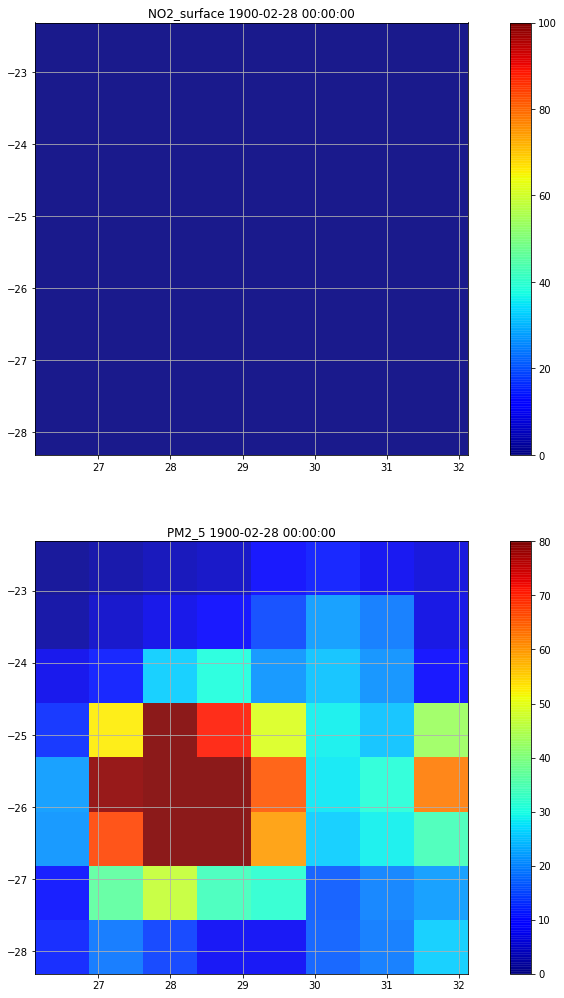

In [11]:
fig, axs = plt.subplots(figsize=(15, 17.5), nrows=len(cams_products))

time_idx = 18

normalisations = [dict(vmin=0, vmax=100), 
                  dict(vmin=0, vmax=80)]

for nn, (fname, norm) in enumerate(zip(cams_products, normalisations)):
    fh = draw_feature(ax=axs[nn], eopatch=mean_cams_eop, 
                      feature=(FeatureType.DATA, fname),
                      time_idx=time_idx, 
                      **norm,
                      alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[nn])

#### Resampled CAMS to 10 km

In [12]:
## location of resampled CAMS (1 km)

resampled_cams_location = str(DATA_DIR/AOIS[0])+'/resampled_cams_10km'
if not os.path.isdir(resampled_cams_location):
    os.makedirs(resampled_cams_location)
    for i in cams_products:
        os.mkdir(resampled_cams_location + '/' + i)
        
# Get resampling dimensions
target_size = bbox_to_dimensions(mean_cams_eop.bbox, 10000)


# Upsample files to 10 km using bilinear interpolaiton
for i in cams_products:
    for j in glob.glob(str(mean_CAMS_location) + '/' + i + '/*.tif'):
        path_in = j
        path_out = re.sub('mean_cams', 'resampled_cams_10km', path_in)
        upscale_tiff(path_in, path_out, target_size)

In [13]:
## Load downscaled CAMS
resampled_cams_location = Path(resampled_cams_location)
downscaled_cams_eops = [load_tiffs(resampled_cams_location/cams_p, 
                        (FeatureType.DATA, cams_p), 
                        offset=OFFSET,
                        data_source='cams') 
             for cams_p in cams_products]

## Merge them into a single EOPatch
downscaled_cams_eop = EOPatch(data={'NO2_surface': downscaled_cams_eops[0].data['NO2_surface'], 
                         'PM2_5': downscaled_cams_eops[1].data['PM2_5']},
                   meta_info={'Names_NO2_surface': downscaled_cams_eops[0].meta_info['Names'],
                              'Names_PM2_5': downscaled_cams_eops[1].meta_info['Names']},
                     timestamp=downscaled_cams_eops[0].timestamp,
                     bbox=downscaled_cams_eops[0].bbox)
del downscaled_cams_eops
downscaled_cams_eop

EOPatch(
  data: {
    NO2_surface: numpy.ndarray(shape=(92, 61, 66, 1), dtype=float32)
    PM2_5: numpy.ndarray(shape=(92, 61, 66, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    Names_NO2_surface: ['CAMS_NO2_day2141_h00.tif', ..., 'CAMS_NO2_day2232_h00.tif'], length=92
    Names_PM2_5: ['CAMS_PM2_5_day2141_h00.tif', ..., 'CAMS_PM2_5_day2232_h00.tif'], length=92
  }
  bbox: BBox(((26.125, -28.315595626831055), (32.125, -22.315595626831055)), crs=CRS('4326'))
  timestamp: [datetime.datetime(1900, 2, 10, 0, 0), ..., datetime.datetime(1900, 5, 12, 0, 0)], length=92
)

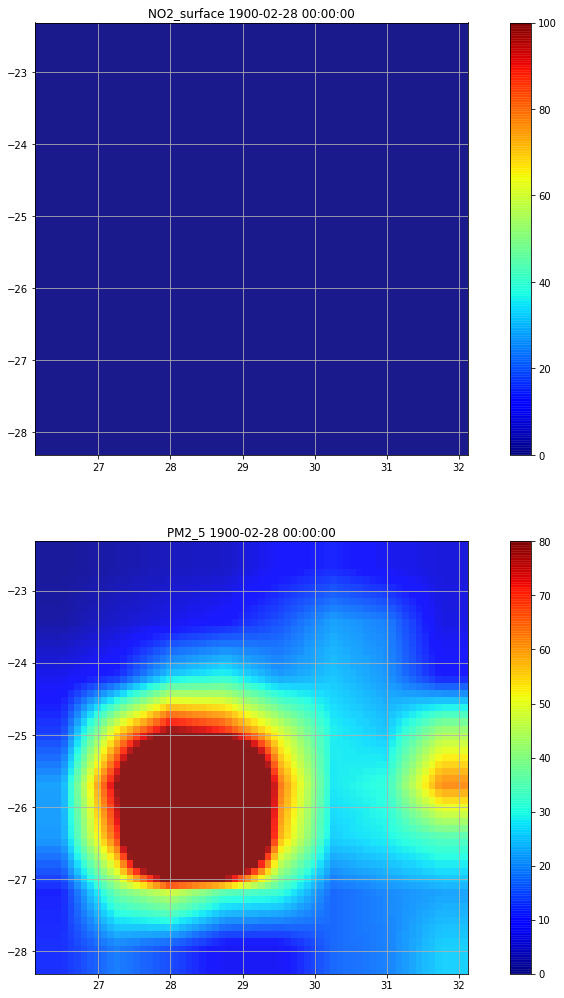

In [14]:
## Plot resampled CAMS 10 km
fig, axs = plt.subplots(figsize=(15, 17.5), nrows=len(cams_products))

time_idx = 18

normalisations = [dict(vmin=0, vmax=100), 
                  dict(vmin=0, vmax=80)]

for nn, (fname, norm) in enumerate(zip(cams_products, normalisations)):
    fh = draw_feature(ax=axs[nn], eopatch=downscaled_cams_eop, 
                      feature=(FeatureType.DATA, fname),
                      time_idx=time_idx, 
                      **norm,
                      alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[nn])

### S5P <a name="cams"></a>
I used it to take the bounding box of S5P

In [15]:
s5p_train_dir = DATA_DIR/AOIS[0]/'sentinel5P'

s5p_products = sorted(os.listdir(s5p_train_dir))

s5p_eops = [load_tiffs(s5p_train_dir/s5p_p, (FeatureType.DATA, s5p_p), offset=OFFSET) 
           for s5p_p in s5p_products]

s5p_eop = EOPatch(data={'NO2': s5p_eops[0].data['NO2'], 
                        'UV_AEROSOL_INDEX': s5p_eops[1].data['UV_AEROSOL_INDEX']},
                 timestamp=s5p_eops[0].timestamp,
                 bbox=s5p_eops[0].bbox)
del s5p_eops
s5p_eop


EOPatch(
  data: {
    NO2: numpy.ndarray(shape=(100, 70, 77, 2), dtype=float32)
    UV_AEROSOL_INDEX: numpy.ndarray(shape=(85, 71, 77, 2), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((26.677331470947365, -27.758826442871097), (31.51909147094736, -23.35722644287111)), crs=CRS('4326'))
  timestamp: [datetime.datetime(1900, 2, 10, 10, 0), ..., datetime.datetime(1900, 5, 12, 12, 0)], length=100
)

### S3 <a name="cams"></a>

## MODIS
EPSG: 4326. Spatial Resolution: 1km, Temporal resolution: Daily

In [16]:
modis_train_dir = DATA_DIR/AOIS[0]/'modis_MCD19A2'
modis_products = sorted(os.listdir(modis_train_dir))

## Load MODIS AOD - Aerosol Optical depth information
modis_eops = [load_tiffs(datapath=modis_train_dir/'MCD19A2_AOD',
                         feature=(FeatureType.DATA, 'AOD'),
                         filename=filename,
                         image_dtype=np.float32,
                         data_source='modis') 
              for filename in sorted(os.listdir(modis_train_dir/'MCD19A2_AOD'))]

## Load MODIS AOD - Optical Depth Quality Index
modis_qa_eops = [load_tiffs(datapath=modis_train_dir/'MCD19A2_AOD_QA',
                            feature=(FeatureType.DATA, 'AOD_QA'),
                            filename=filename,
                            image_dtype=np.float32,
                            data_source='modis') 
                 for filename in sorted(os.listdir(modis_train_dir/'MCD19A2_AOD_QA'))]



In [18]:
## Function to encode the MODIS QA LAYER and return mask array with just clear and high quality pixels.
def ValidData(eopatch,band,min_modis_qa):
    eopatch.data['AOD_QA'][..., band][eopatch.data['AOD_QA'][..., band] == min_modis_qa] = np.nan
    modis_AOD_QA = eopatch.data['AOD_QA'][..., band]

    qa_data = np.unique(modis_AOD_QA)
    qa_data = qa_data.astype(np.int16)
    qa_data = qa_data.tolist()
    qa_data = [x for x in qa_data if x != 0]

    for i in qa_data:
        mask811 = 0b111100000000
        mask02 =  0b000000000111
        qa811 = (i & mask811) >> 8
        qa02 = (i & mask02) >> 0
        if qa811 == 0 and qa02 == 1:
            i = float(i)
            modis_AOD_QA=np.where(modis_AOD_QA==i, 0, modis_AOD_QA)
        else:
            i = float(i)
            modis_AOD_QA=np.where(modis_AOD_QA==i, 1, modis_AOD_QA)


    return modis_AOD_QA

In [19]:


## Task to add masked array for AOD
feature = (FeatureType.DATA, 'AOD_Valid')
add_feature = AddFeature(feature)


""" This task related to add daily mask
## Task to add masked array for AOD
feature_mask = (FeatureType.MASK_TIMELESS, 'MASK_AOD')
add_feature_mask = AddFeature(feature_mask)
"""

## Tasks to compute statistics of valid AOD (mean, maximum, minimum) 
mean = MapFeatureTask((FeatureType.DATA,'AOD_Valid'),  # input features
                         (FeatureType.DATA_TIMELESS,'Stats_MODIS'),  # output feature
                         np.nanmean,                    # a function to apply to each feature
                         axis=-1)                  


maximum = MapFeatureTask((FeatureType.DATA,'AOD_Valid'),  # input features
                         (FeatureType.DATA_TIMELESS,'Stats_MODIS'),  # output feature
                         np.nanmax,                    # a function to apply to each feature
                         axis=-1)                   

minimum = MapFeatureTask((FeatureType.DATA,'AOD_Valid'),  # input features
                         (FeatureType.DATA_TIMELESS,'Stats_MODIS'),  # output feature
                         np.nanmin,                    # a function to apply to each feature
                         axis=-1)                   


## location of exported statisitcs MODIS
modis_statistics = ['daily_mean_AOD','daily_maximum_AOD','daily_minimum_AOD']
statistics_modis = str(DATA_DIR/AOIS[0])+'/statistics_modis'
if not os.path.isdir(statistics_modis):
    os.makedirs(statistics_modis)
    for i in modis_statistics:
        os.mkdir(statistics_modis + '/' + i)
        

## Task to export the merged tiff (mean of daily measurments)
export_tiff = ExportToTiff((FeatureType.DATA_TIMELESS, 'Stats_MODIS'))







In [20]:
## Filter MODIS pixels 
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for index, modis_eop in enumerate(modis_eops):
        ## Call the AOD_QA EOpatch for the same AOD EOpatch
        modis_qa_eop = modis_qa_eops[index]
        
        ## Check how many bands in the AOD eopatch
        modis_AOD = modis_eop.data['AOD']
        t, w, h, b = modis_AOD.shape
        
        ## Loop through bands
        Masked_data=[]
        for band in range(b):
            ## Take the band in the AOD Eopatch
            MODIS_AOD = modis_eop.data['AOD'][..., band]
            
            ## Creat mask of clear and high quality pixels for the band in AOD Eopatch from MODIS QA Eopatch
            valmask = ValidData(modis_qa_eop,band,min_modis_qa = 0)

            ## Creat Masked Array of MODIS AOD
            Masked_MODIS_AOD = np.ma.array(MODIS_AOD, mask=valmask,fill_value=np.nan)
            
            ## Put the maske array in a list 
            Masked_data.append(Masked_MODIS_AOD)
        
        ## Stack the mask arrays for the availabe bands into one array 
        data = np.ma.stack(Masked_data, axis=-1)
        
        ## Add the masked arrays as data in the AOD Eopatch 
        modis_eop = add_feature.execute(modis_eop, data)


       
     
    

In [22]:
MODIS_NO_DATA_VALUE = -28672

##  Compute statistcs 
##  Add warning filter to avoid RuntimeWarnings in this block for an array of all NaNs 
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for modis_eop in modis_eops:
        modis_eop.data['AOD_Valid'][modis_eop.data['AOD_Valid'] == MODIS_NO_DATA_VALUE] = np.nan
        tiffname = modis_eop.meta_info['Names'][0]
        
        for stats, file_name in [(mean, 'daily_mean_AOD'), (maximum, 'daily_maximum_AOD'), (minimum, 'daily_minimum_AOD')]:
            stats(modis_eop)
            
            filled_values = modis_eop.data_timeless['Stats_MODIS'][0]
            filled_values.data[filled_values.data == 1.e+20] = np.nan
            modis_eop.data_timeless['Stats_MODIS'][0] = filled_values
            
            modis_eop.data_timeless['Stats_MODIS'] = np.resize(modis_eop.data_timeless['Stats_MODIS'],(455,502,1))
            export_tiff.execute(modis_eop, filename=str(statistics_modis)+'/'+file_name+'/'+tiffname)

        """ This block to export the daily mask but add "daily_mask" element to modis_statistics list
        
        data = modis_eop.data_timeless['Stats_MODIS']

        ## Create mask from the masked array
        mask = np.ma.make_mask(data)        
        modis_eop = add_feature_mask.execute(modis_eop, mask)
        export_tiff.execute(modis_eop, filename=str(statistics_modis)+'/'+'daily_mask'+'/'+tiffname)
        
        """
        
    
del modis_eops   

In [23]:
## Load the daily statistcs MODIS products
statistics_modis=Path(statistics_modis)
stats_modis_eops = [load_tiffs(statistics_modis/modis, 
                               (FeatureType.DATA, modis),
                               image_dtype=np.float32,
                               data_source='modis')
                    for modis in modis_statistics]

## Merge them into a single EOPatch

stats_modis_eop = EOPatch(data={'daily_mean_AOD': stats_modis_eops[0].data['daily_mean_AOD'], 
                         'daily_maximum_AOD': stats_modis_eops[1].data['daily_maximum_AOD'],
                               'daily_minimum_AOD': stats_modis_eops[2].data['daily_minimum_AOD'],},
                          meta_info={'tiff_names': stats_modis_eops[0].meta_info['Names']},
                              timestamp=stats_modis_eops[0].timestamp,
                              bbox=stats_modis_eops[0].bbox)
del stats_modis_eops
stats_modis_eop

EOPatch(
  data: {
    daily_maximum_AOD: numpy.ndarray(shape=(91, 455, 502, 1), dtype=float32)
    daily_mean_AOD: numpy.ndarray(shape=(91, 455, 502, 1), dtype=float32)
    daily_minimum_AOD: numpy.ndarray(shape=(91, 455, 502, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    tiff_names: ['MCD19A2_day2141.tif', ..., 'MCD19A2_day2232.tif'], length=91
  }
  bbox: BBox(((26.632329348992013, -27.816682446357305), (31.56814644204169, -23.342983686720643)), crs=CRS('4326'))
  timestamp: [datetime.datetime(1900, 2, 10, 0, 0), ..., datetime.datetime(1900, 5, 12, 0, 0)], length=91
)

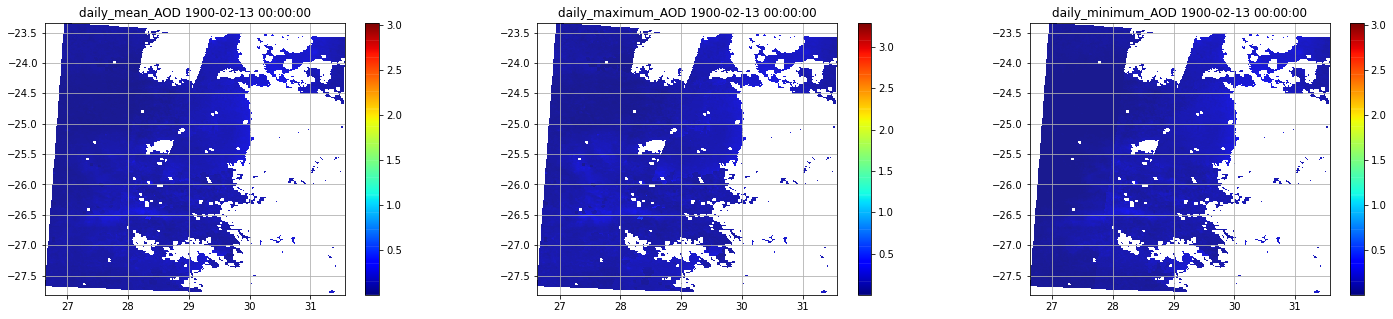

In [26]:
## Plot Valid MODIS Data (mean,maximum,minimium)
fig, axs = plt.subplots(figsize=(25,5), ncols=3)

time_idx = 3

normalisations = [dict(vmin=np.nanmin(stats_modis_eop.data[modis_product]), 
                       vmax=np.nanmax(stats_modis_eop.data[modis_product])) 
                  for modis_product in modis_statistics]


for nn, (fname, norm) in enumerate(zip(modis_statistics, normalisations)):
    fh = draw_feature(ax=axs[nn], eopatch=stats_modis_eop, 
                      feature=(FeatureType.DATA, fname), 
                      **norm,
                      time_idx = time_idx,
                      alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[nn])
    

### Temporal linear interpolation

In [27]:
## Temporal linear interpolation
from eolearn.features import LinearInterpolation, BSplineInterpolation

for modis_statistic in modis_statistics:
    linear_interp = LinearInterpolation(modis_statistic)
    linear_interp(stats_modis_eop)


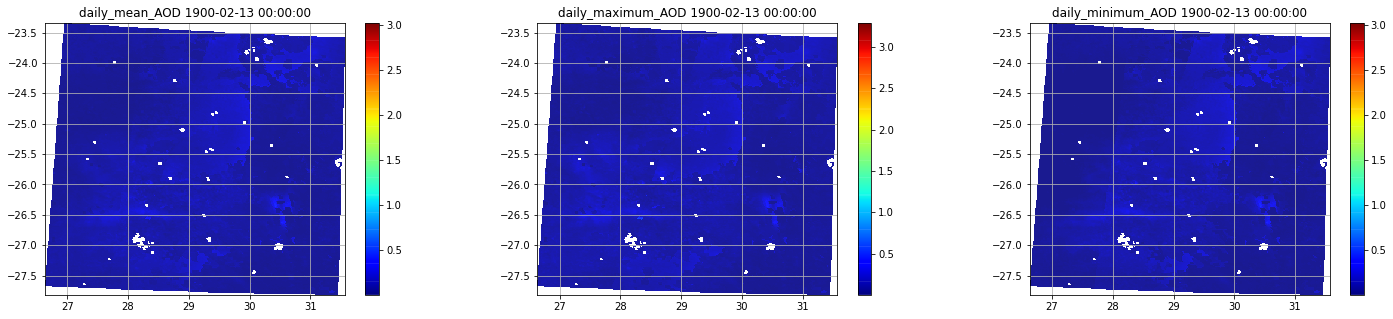

In [28]:
## Plot filled MODIS Data in time, (mean,maximum,minimium)
fig, axs = plt.subplots(figsize=(25,5), ncols=3)

time_idx = 3

normalisations = [dict(vmin=np.nanmin(stats_modis_eop.data[modis_product]), 
                       vmax=np.nanmax(stats_modis_eop.data[modis_product])) 
                  for modis_product in modis_statistics]


for nn, (fname, norm) in enumerate(zip(modis_statistics, normalisations)):
    fh = draw_feature(ax=axs[nn], eopatch=stats_modis_eop, 
                      feature=(FeatureType.DATA, fname), 
                      **norm,
                      time_idx = time_idx,
                      alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[nn])

##### Fill the remaining gaps using the average daily AOD (constant value for all missing pixels)


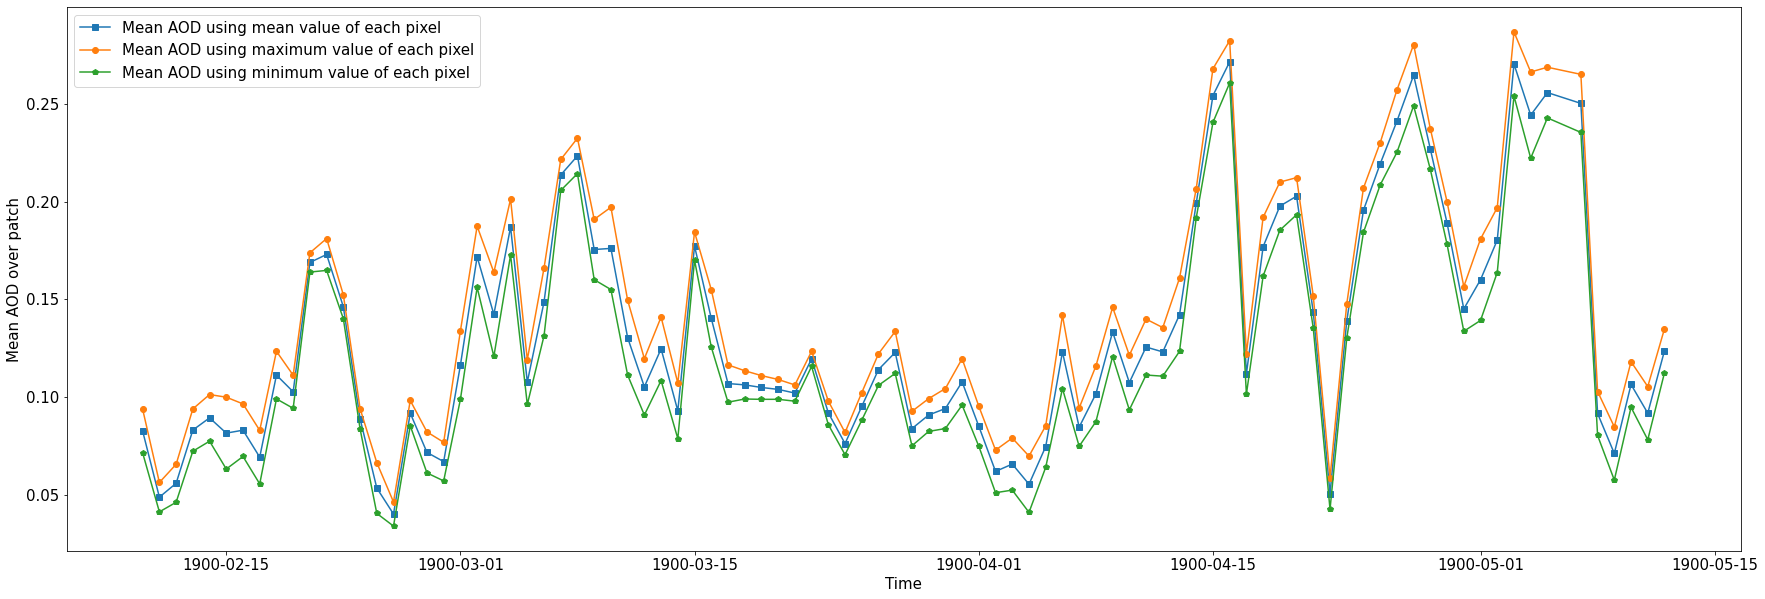

In [29]:
## This block is not important - just to see the trend of mean AOD value over the patch

## calculate the average using daily_mean_AOD, daily_maximum_AOD, daily_minimum_AOD
mean_AOD = stats_modis_eop.data['daily_mean_AOD']
t, w, h, _ = mean_AOD.shape
avg_mean_AOD = np.nanmean(mean_AOD.reshape(t, w * h).squeeze(), axis=1)


max_AOD = stats_modis_eop.data['daily_maximum_AOD']
avg_max_AOD = np.nanmean(max_AOD.reshape(t, w * h).squeeze(), axis=1)


min_AOD = stats_modis_eop.data['daily_minimum_AOD']
avg_min_AOD = np.nanmean(min_AOD.reshape(t, w * h).squeeze(), axis=1)

time = np.array(stats_modis_eop.timestamp)



## Plot the constant value across the time series
fig = plt.figure(figsize=(30,10))
plt.plot(time, avg_mean_AOD, 's-', label = 'Mean AOD using mean value of each pixel ')
plt.plot(time, avg_max_AOD, 'o-', label='Mean AOD using maximum value of each pixel')
plt.plot(time, avg_min_AOD, 'p-', label='Mean AOD using minimum value of each pixel')


plt.xlabel('Time', fontsize=15)
plt.ylabel('Mean AOD over patch', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc=2, prop={'size': 15});

In [30]:
## Loop in the patch and sign the mean value for each MODIS scene
mean_AOD = stats_modis_eop.data['daily_mean_AOD']
t, w, h, _ = mean_AOD.shape

for i in range(t):
    for a in modis_statistics:
        filled_values = stats_modis_eop.data[a][i]
        filled_values[np.isnan(filled_values)] = np.nanmean(filled_values)
        stats_modis_eop.data[a][i] = filled_values
        
 
    

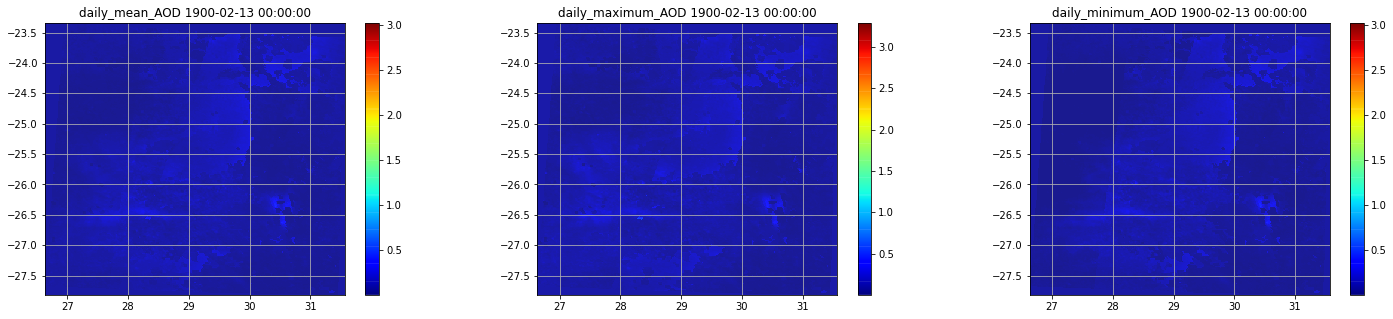

In [32]:
## Plot filled MODIS Data, (mean,maximum,minimium)
fig, axs = plt.subplots(figsize=(25,5), ncols=3)

time_idx = 3

normalisations = [dict(vmin=np.min(stats_modis_eop.data[modis_product]), 
                       vmax=np.max(stats_modis_eop.data[modis_product])) 
                  for modis_product in modis_statistics]


for nn, (fname, norm) in enumerate(zip(modis_statistics, normalisations)):
    fh = draw_feature(ax=axs[nn], eopatch=stats_modis_eop, 
                      feature=(FeatureType.DATA, fname), 
                      **norm,
                      time_idx = time_idx,
                      alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[nn])

In [33]:
## Export the filled MODIS AOD

filled_modis_AOD = str(DATA_DIR/AOIS[0])+'/filled_modis_AOD'
if not os.path.isdir(filled_modis_AOD):
    os.makedirs(filled_modis_AOD)
    for i in modis_statistics:
        os.mkdir(filled_modis_AOD + '/' + i)
        

feature = (FeatureType.DATA_TIMELESS, 'filled_AOD')
add_feature = AddFeature(feature)
        
for i in range(t):
    tiffname = stats_modis_eop.meta_info['tiff_names'][i]
    for a in modis_statistics:
        ## extract the band
        data = stats_modis_eop.data[a][i]
        add_feature.execute(stats_modis_eop,data)
        
        ## Task to export the band (mean of daily measurments)
        export_tiff = ExportToTiff((FeatureType.DATA_TIMELESS, 'filled_AOD'))
        export_tiff.execute(stats_modis_eop, filename=str(filled_modis_AOD)+'/'+a+'/'+tiffname)



#### Resampling MODIS data 
- 1 km to match NO2 data with the same bounding box of S5P.
- 10 km to match CAMS data with the same bounding box of CAMS.
 


In [34]:
## location of resampled MODIS (1 km) - WILL USED TO predict S5P

resampled_modis_1km = str(DATA_DIR/AOIS[0])+'/resampled_modis_1km'
if not os.path.isdir(resampled_modis_1km):
    os.makedirs(resampled_modis_1km)
    for i in modis_statistics:
        os.mkdir(resampled_modis_1km + '/' + i)
        
# Get resampling dimensions
target_size = bbox_to_dimensions(s5p_eop.bbox, 1000)


#Sampling files to 1 km using bilinear interpolaiton
for i in modis_statistics:
    for j in glob.glob(str(filled_modis_AOD) + '/' + i + '/*.tif'):
        path_in = j
        path_out = re.sub('filled_modis_AOD', 'resampled_modis_1km', path_in)
        upscale_tiff(path_in, path_out, target_size)
        


In [35]:
## location of resampled MODIS (10 km) - WILL USED TO predict CAMS

resampled_modis_10km = str(DATA_DIR/AOIS[0])+'/resampled_modis_10km'
if not os.path.isdir(resampled_modis_10km):
    os.makedirs(resampled_modis_10km)
    for i in modis_statistics:
        os.mkdir(resampled_modis_10km + '/' + i)
        
# Get resampling dimensions
target_size = bbox_to_dimensions(mean_cams_eop.bbox, 10000)


#Sampling files to 1 km using bilinear interpolaiton
for i in modis_statistics:
    for j in glob.glob(str(filled_modis_AOD) + '/' + i + '/*.tif'):
        path_in = j
        path_out = re.sub('filled_modis_AOD', 'resampled_modis_10km', path_in)
        upscale_tiff(path_in, path_out, target_size)

In [36]:
## Load resampled MODIS DATA - 1 km "Will be used later when S5P data is ready"
resampled_modis = Path(resampled_modis_1km)
resampled_modis_1km_eops = [load_tiffs(resampled_modis/modis, 
                        (FeatureType.DATA, modis), 
                        image_dtype=np.float32,
                        data_source='modis') 
             for modis in modis_statistics]



## Merge them into a single EOPatch
resampled_modis_1km_eop = EOPatch(data={'daily_mean_AOD': resampled_modis_1km_eops[0].data['daily_mean_AOD'], 
                         'daily_maximum_AOD': resampled_modis_1km_eops[1].data['daily_maximum_AOD'],
                               'daily_minimum_AOD': resampled_modis_1km_eops[2].data['daily_minimum_AOD'],
                                },
                          meta_info={'tiff_names': resampled_modis_1km_eops[0].meta_info['Names']},
                              timestamp=resampled_modis_1km_eops[0].timestamp,
                              bbox=s5p_eop.bbox)


del resampled_modis_1km_eops

resampled_modis_1km_eop

EOPatch(
  data: {
    daily_maximum_AOD: numpy.ndarray(shape=(91, 494, 480, 1), dtype=float32)
    daily_mean_AOD: numpy.ndarray(shape=(91, 494, 480, 1), dtype=float32)
    daily_minimum_AOD: numpy.ndarray(shape=(91, 494, 480, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    tiff_names: ['MCD19A2_day2141.tif', ..., 'MCD19A2_day2232.tif'], length=91
  }
  bbox: BBox(((26.677331470947365, -27.758826442871097), (31.51909147094736, -23.35722644287111)), crs=CRS('4326'))
  timestamp: [datetime.datetime(1900, 2, 10, 0, 0), ..., datetime.datetime(1900, 5, 12, 0, 0)], length=91
)

In [37]:
## Load resampled MODIS DATA - 10 km (for CAMS)
resampled_modis = Path(resampled_modis_10km)
resampled_modis_10km_eops = [load_tiffs(resampled_modis/modis, 
                        (FeatureType.DATA, modis), 
                        image_dtype=np.float32,
                        data_source='modis') 
             for modis in modis_statistics]



## Merge them into a single EOPatch
resampled_modis_10km_eop = EOPatch(data={'daily_mean_AOD': resampled_modis_10km_eops[0].data['daily_mean_AOD'], 
                         'daily_maximum_AOD': resampled_modis_10km_eops[1].data['daily_maximum_AOD'],
                               'daily_minimum_AOD': resampled_modis_10km_eops[2].data['daily_minimum_AOD'],
                                },
                          meta_info={'tiff_names': resampled_modis_10km_eops[0].meta_info['Names']},
                              timestamp=resampled_modis_10km_eops[0].timestamp,
                              bbox=mean_cams_eop.bbox)


del resampled_modis_10km_eops

resampled_modis_10km_eop

EOPatch(
  data: {
    daily_maximum_AOD: numpy.ndarray(shape=(91, 61, 66, 1), dtype=float32)
    daily_mean_AOD: numpy.ndarray(shape=(91, 61, 66, 1), dtype=float32)
    daily_minimum_AOD: numpy.ndarray(shape=(91, 61, 66, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    tiff_names: ['MCD19A2_day2141.tif', ..., 'MCD19A2_day2232.tif'], length=91
  }
  bbox: BBox(((26.125, -28.315595626831055), (32.125, -22.315595626831055)), crs=CRS('4326'))
  timestamp: [datetime.datetime(1900, 2, 10, 0, 0), ..., datetime.datetime(1900, 5, 12, 0, 0)], length=91
)

## Check boundary of CAMS & resample MODIS(10 KM)

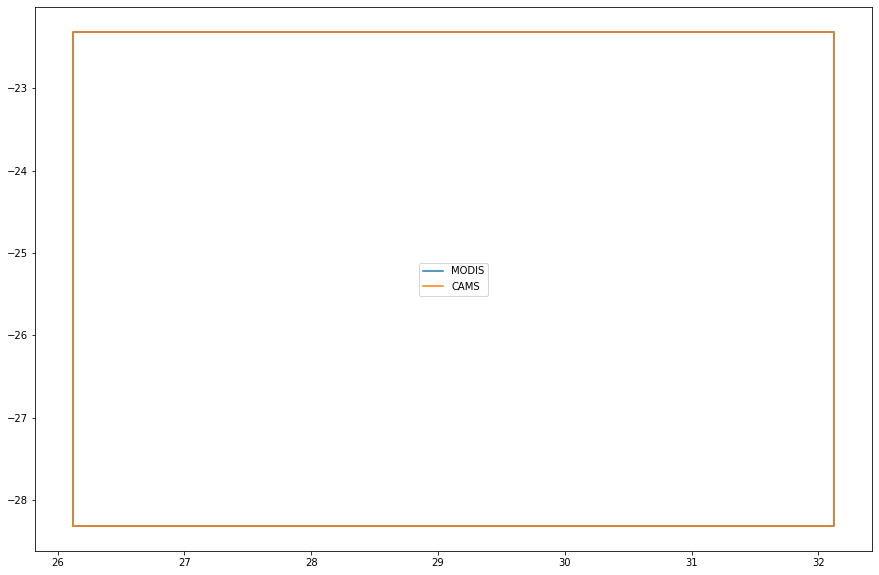

In [38]:
fig, ax = plt.subplots(figsize=(15,10))

for eop, name in [(resampled_modis_10km_eop, 'MODIS'), 
                  (downscaled_cams_eop, 'CAMS')]:
    cx, cy = zip(*eop.bbox.get_polygon())
    
    ax.plot(cx, cy, label=name)

##bbox_ita.to_crs(epsg=4326).boundary.plot(ax=ax, edgecolor='k', 
  ##                                       linewidth=2, label='Submission BBOX')

ax.legend();

### Merge MODIS 10 km & CAMS into a single EOPatch


In [39]:
## Merge them into a single EOPatch
modis_cams_eop = EOPatch(data={'NO2_surface': downscaled_cams_eop.data['NO2_surface'],
                                    'PM2_5': downscaled_cams_eop.data['PM2_5'],
                                    'daily_mean_AOD': resampled_modis_10km_eop.data['daily_mean_AOD'],
                                    'daily_maximum_AOD': resampled_modis_10km_eop.data['daily_maximum_AOD'],
                                    'daily_minimum_AOD': resampled_modis_10km_eop.data['daily_minimum_AOD']
                                   },
                   meta_info={'Names_NO2_surface': downscaled_cams_eop.meta_info['Names_NO2_surface'],
                              'Names_PM2_5': downscaled_cams_eop.meta_info['Names_PM2_5'],
                              'Names_MODIS': resampled_modis_10km_eop.meta_info['tiff_names']
                             },
                     timestamp=downscaled_cams_eop.timestamp,
                     bbox=downscaled_cams_eop.bbox)

modis_cams_eop

EOPatch(
  data: {
    NO2_surface: numpy.ndarray(shape=(92, 61, 66, 1), dtype=float32)
    PM2_5: numpy.ndarray(shape=(92, 61, 66, 1), dtype=float32)
    daily_maximum_AOD: numpy.ndarray(shape=(91, 61, 66, 1), dtype=float32)
    daily_mean_AOD: numpy.ndarray(shape=(91, 61, 66, 1), dtype=float32)
    daily_minimum_AOD: numpy.ndarray(shape=(91, 61, 66, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    Names_MODIS: ['MCD19A2_day2141.tif', ..., 'MCD19A2_day2232.tif'], length=91
    Names_NO2_surface: ['CAMS_NO2_day2141_h00.tif', ..., 'CAMS_NO2_day2232_h00.tif'], length=92
    Names_PM2_5: ['CAMS_PM2_5_day2141_h00.tif', ..., 'CAMS_PM2_5_day2232_h00.tif'], length=92
  }
  bbox: BBox(((26.125, -28.315595626831055), (32.125, -22.315595626831055)), crs=CRS('4326'))
  timestamp: [datetime.datetime(1900, 2, 10, 0, 0), ..., datetime.datetime(1900, 5, 12

### ERA5 <a name="cams"></a>

### Land cover <a name="cams"></a>

### DEM <a name="cams"></a>

In [45]:
sa_dem_train_dir = DATA_DIR/AOIS[0]
sa_dem_eop = load_tiffs(sa_dem_train_dir, 
                        (FeatureType.DATA_TIMELESS, 'EU_DEM'),
                        filename='COP_DSM_south_africa_GLO-30.tif')
sa_dem_eop

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    EU_DEM: numpy.ndarray(shape=(17766, 18664, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((26.56263888888889, -28.18263888888889), (31.747083333333336, -23.24763888888889)), crs=CRS('4326'))
  timestamp: []
)

#### Resampling DEM to 1km (for CAMS) , 10km (for S5P)

In [47]:
## Resampling DEM to 1 Km with the same bounding box of S5P

## location of resampled DEM (1 km)
sa_dem_train_dir = str(DATA_DIR/AOIS[0])+'/DEM'

resampled_DEM = str(DATA_DIR/AOIS[0])+'/resampled_DEM'
if not os.path.isdir(resampled_DEM):
    os.makedirs(resampled_DEM)

        
# Get resampling dimensions
target_size = bbox_to_dimensions(s5p_eop.bbox, 1000)


#Sampling files to 1 km using bilinear interpolaiton
for j in glob.glob(str(sa_dem_train_dir) + '/*.tif'):
    path_in = j
    path_out = re.sub('DEM', 'resampled_DEM', path_in)
    upscale_tiff(path_in, path_out, target_size)

In [48]:
## Resampling DEM to 10 Km with the same bounding box of CAMS

## location of resampled DEM (10 km)
sa_dem_train_dir = str(DATA_DIR/AOIS[0])+'/DEM'

resampled_DEM_10km = str(DATA_DIR/AOIS[0])+'/resampled_DEM_10km'
if not os.path.isdir(resampled_DEM_10km):
    os.makedirs(resampled_DEM_10km)

        
# Get resampling dimensions
target_size = bbox_to_dimensions(mean_cams_eop.bbox, 10000)


#Sampling files to 1 km using bilinear interpolaiton
for j in glob.glob(str(sa_dem_train_dir) + '/*.tif'):
    path_in = j
    path_out = re.sub('DEM', 'resampled_DEM_10km', path_in)
    upscale_tiff(path_in, path_out, target_size)

In [49]:
## load resampled DEM - 1 km "Will be added later to S5P eopatch"
resampled_sa_dem_train_dir = DATA_DIR/AOIS[0]/'resampled_DEM'
resampled_sa_dem_eop = load_tiffs(resampled_sa_dem_train_dir, 
                        (FeatureType.DATA_TIMELESS, 'SA_DEM'))
resampled_sa_dem_eop

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    SA_DEM: numpy.ndarray(shape=(494, 480, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((26.56263888888889, -28.18263888888889), (31.747083333333336, -23.24763888888889)), crs=CRS('4326'))
  timestamp: []
)

In [40]:
## load resampled DEM - 10 km 
resampled_sa_dem_train_dir = DATA_DIR/AOIS[0]/'resampled_DEM_10km'
resampled_sa_dem_eop_10km = load_tiffs(resampled_sa_dem_train_dir, 
                        (FeatureType.DATA_TIMELESS, 'SA_DEM'))
resampled_sa_dem_eop_10km

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    SA_DEM: numpy.ndarray(shape=(61, 66, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((26.56263888888889, -28.18263888888889), (31.747083333333336, -23.24763888888889)), crs=CRS('4326'))
  timestamp: []
)

##### Merge DEM & CAMS & MODIS into single eopatch


In [41]:
## Merge them into a single EOPatch
modis_cams_dem_eop = EOPatch(data={'NO2_surface': modis_cams_eop.data['NO2_surface'],
                                    'PM2_5': modis_cams_eop.data['PM2_5'],
                                    'daily_mean_AOD': modis_cams_eop.data['daily_mean_AOD'],
                                    'daily_maximum_AOD': modis_cams_eop.data['daily_maximum_AOD'],
                                    'daily_minimum_AOD': modis_cams_eop.data['daily_minimum_AOD'],
                                   },
                             data_timeless={
                                 'SA_DEM': resampled_sa_dem_eop_10km.data_timeless['SA_DEM']
                             },
                   meta_info={'Names_NO2_surface': modis_cams_eop.meta_info['Names_NO2_surface'],
                              'Names_PM2_5': modis_cams_eop.meta_info['Names_PM2_5'],
                              'Names_MODIS': modis_cams_eop.meta_info['Names_MODIS']
                             },
                     timestamp=modis_cams_eop.timestamp,
                     bbox=modis_cams_eop.bbox)

modis_cams_dem_eop

EOPatch(
  data: {
    NO2_surface: numpy.ndarray(shape=(92, 61, 66, 1), dtype=float32)
    PM2_5: numpy.ndarray(shape=(92, 61, 66, 1), dtype=float32)
    daily_maximum_AOD: numpy.ndarray(shape=(91, 61, 66, 1), dtype=float32)
    daily_mean_AOD: numpy.ndarray(shape=(91, 61, 66, 1), dtype=float32)
    daily_minimum_AOD: numpy.ndarray(shape=(91, 61, 66, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    SA_DEM: numpy.ndarray(shape=(61, 66, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    Names_MODIS: ['MCD19A2_day2141.tif', ..., 'MCD19A2_day2232.tif'], length=91
    Names_NO2_surface: ['CAMS_NO2_day2141_h00.tif', ..., 'CAMS_NO2_day2232_h00.tif'], length=92
    Names_PM2_5: ['CAMS_PM2_5_day2141_h00.tif', ..., 'CAMS_PM2_5_day2232_h00.tif'], length=92
  }
  bbox: BBox(((26.125, -28.315595626831055), (32.125, -22.315595626831055)), crs=CRS('4326'))
  timestamp: [datetime.

In [42]:
## Save the eopatch

path_out = str(DATA_DIR/AOIS[0])+'/eopatches/'
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveTask(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

save.execute(modis_cams_dem_eop)

EOPatch(
  data: {
    NO2_surface: numpy.ndarray(shape=(92, 61, 66, 1), dtype=float32)
    PM2_5: numpy.ndarray(shape=(92, 61, 66, 1), dtype=float32)
    daily_maximum_AOD: numpy.ndarray(shape=(91, 61, 66, 1), dtype=float32)
    daily_mean_AOD: numpy.ndarray(shape=(91, 61, 66, 1), dtype=float32)
    daily_minimum_AOD: numpy.ndarray(shape=(91, 61, 66, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    SA_DEM: numpy.ndarray(shape=(61, 66, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    Names_MODIS: ['MCD19A2_day2141.tif', ..., 'MCD19A2_day2232.tif'], length=91
    Names_NO2_surface: ['CAMS_NO2_day2141_h00.tif', ..., 'CAMS_NO2_day2232_h00.tif'], length=92
    Names_PM2_5: ['CAMS_PM2_5_day2141_h00.tif', ..., 'CAMS_PM2_5_day2232_h00.tif'], length=92
  }
  bbox: BBox(((26.125, -28.315595626831055), (32.125, -22.315595626831055)), crs=CRS('4326'))
  timestamp: [datetime.

In [43]:
## Load the final eopatch
path_in = str(DATA_DIR/AOIS[0])+'/eopatches/'

load = LoadTask(path_in)
eo_south_africa = load.execute()

In [44]:
eo_south_africa

EOPatch(
  data: {
    NO2_surface: numpy.ndarray(shape=(92, 61, 66, 1), dtype=float32)
    PM2_5: numpy.ndarray(shape=(92, 61, 66, 1), dtype=float32)
    daily_maximum_AOD: numpy.ndarray(shape=(91, 61, 66, 1), dtype=float32)
    daily_mean_AOD: numpy.ndarray(shape=(91, 61, 66, 1), dtype=float32)
    daily_minimum_AOD: numpy.ndarray(shape=(91, 61, 66, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    SA_DEM: numpy.ndarray(shape=(61, 66, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    Names_MODIS: ['MCD19A2_day2141.tif', ..., 'MCD19A2_day2232.tif'], length=91
    Names_NO2_surface: ['CAMS_NO2_day2141_h00.tif', ..., 'CAMS_NO2_day2232_h00.tif'], length=92
    Names_PM2_5: ['CAMS_PM2_5_day2141_h00.tif', ..., 'CAMS_PM2_5_day2232_h00.tif'], length=92
  }
  bbox: BBox(((26.125, -28.315595626831055), (32.125, -22.315595626831055)), crs=CRS('4326'))
  timestamp: [datetime.

### SPOT <a name="cams"></a>

### Data merging

## Exploratory analysis <a name="exploratory-analysis"></a>

## Modelling and validation <a name="modelling-and-validation"></a>

## Prediction <a name="prediction"></a>